<a href="https://colab.research.google.com/github/aleguma/tf-cert/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

The main premise is that we leverage the knowledge of a model trained in a similar problem space (patterns/weights) and then we use/tune those learned patterns to a different but related specific problem. Typical application domains are computer vision and NLP problems.

Why use *transfer learning*?

It can leverage an existing neural network architecture **proven to work** on problems similar to our own.

It can leverage a working network architecture whic has **already learned patterns** on similar data to our own (often results in great results with fewer data).

In the previous notebook, we covered transfer learning feature extraction, now it is time to learn about a new kind of transfer learning: fine-tuning!

## Feature extraction vs. Fine-tuning

We covered feature extraction in module 04 (previous notebook). We are going to cover now fine-tuning.

For feature extraction, the working architecture of the pretrained module stays the same, the patterns/weights are frozen and we add a custom final layer that gets trained on custom (input) data. On the other hand, fine-tuning unfreezes top layers (unfrozen weights get updated during training), which are tuned on custom data. Bottom layers (may) stay frozen, which would make all weights to be updated but starting the training with the pretrained weight values (patterns). In fine-tuning, there is no limit on how many layers you can freeze/unfreeze and train on your own custom data set. 

Fine-tuning usually requires mode data than feature extraction.


## What we are going to cover (broadly)

* Introduce **fine-tuning transfer learning** with TensorFlow
* Introduce **Keras Functional API** to build models
* Using a small dataset to experiment faster (e.g., 10% of training samples)
* **Data augmentation** (making your training set more dicerse without adding samples) as a layer within the model
* Running a series of experiments on our Food Vision data
* Introduce the **`ModelCheckpoint` callback** to save intermediate training results

In [1]:
# Check if we are using a GPU
!nvidia-smi

Mon Sep 26 11:05:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we have created a bunch of helper functions, now we could rewrite them all, however, this is tedious. 

So it is a good idea to put the functions you will need/want to use again in a script you can download and import into your notebooks (or elsewhere). 

We have done this for some of the functions we have used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Getting the helper_functions library (.py)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-26 11:05:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-26 11:05:14 (73.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we are going to use in this notebook, so we do not have to rewrite them again
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note**: If you are running this notebook in Google Colab, when it times out, Colab will delete `helper_functions.py`. So you will have to re-download it if you want to access the functions there. 

## Let's get some data

This time, we are going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

Check the complete documentation of `tf.keras.applications` in this [link](https://www.tensorflow.org/api_docs/python/tf/keras/applications). 

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")  # function inside our helper_function library!

--2022-09-26 11:05:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   167MB/s    in 1.0s    

2022-09-26 11:05:19 (167 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")   # function inside our helper_function library!

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [6]:
# We have same dataset as in module 04! We could check it and get familiar with it, but we already are!
# So...

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
# Import TensorFlow
import tensorflow as tf

# Before we used ImageDataGenerator from tf.keras.preprocessing.image
# Now we are going to use image_dataset_from_directory from tf.keras.preprocessing
# Why? This last one creates a tf.data.Dataset object and it is faster
# So ImageDataGenerator is the original one, and the other is an improved version of it
# The usage is very similar! 
# But now we also do not have to create an image data generator instance and then apply the method flow_from_directory; so we do all in just one shoot!

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",  # type of the classes / problem 
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical", 
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Let's briefly check it
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# BatchDataset type, meaning that the function has already split the data into batches!
# The batch is also indicated by the None dimension in the tensor shape! So each batch is composed by 32 images of shape (224, 224, 3)
# The labels are one-hot encoded vectors for 10 classes! So 0 for every class that is not the label, and 1 where it actually corresponds to the class label (encoded index)! Batches of 32 as well ofc!

So the parameters and info of the (input) dataset shapes indicated above establish that:

* Number of total samples (750 images, 75 per class)
* Number of classes (10 types of food)
* Batch size (default is 32)
* Image size (height, width)
* Number of color channels (red, green, blue)
* Number of classes in label tensors (10 types of food)

In [11]:
# Check out the class names of our dataset
train_data_10_percent.class_names  # very handy attribute!

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):  # will get the first batch and unravel it, take it off and get the samples!
  print(images, labels)   # the unraveling comes out in a tuple of images and labels separate

tf.Tensor(
[[[[8.20038300e+01 6.90038300e+01 3.48587379e+01]
   [8.64977646e+01 7.30625000e+01 3.80625000e+01]
   [8.20993347e+01 6.80993347e+01 3.16484375e+01]
   ...
   [1.04142204e+02 4.28280640e+01 5.18169823e+01]
   [1.28102646e+02 4.90150108e+01 6.30663376e+01]
   [1.34072784e+02 4.40885544e+01 6.08501587e+01]]

  [[7.63405609e+01 6.33405609e+01 2.91954727e+01]
   [8.96112823e+01 7.61760178e+01 4.03676643e+01]
   [9.74735336e+01 8.34735336e+01 4.51655006e+01]
   ...
   [8.86562195e+01 3.16502495e+01 3.85130768e+01]
   [1.15169121e+02 4.22268829e+01 5.20151405e+01]
   [1.29320862e+02 4.27431259e+01 5.44943657e+01]]

  [[7.54196396e+01 6.54196396e+01 3.02745552e+01]
   [8.37833252e+01 7.29127884e+01 3.60422516e+01]
   [1.06118622e+02 9.29786301e+01 5.40977325e+01]
   ...
   [7.12137299e+01 2.32274590e+01 2.59936600e+01]
   [1.03907928e+02 4.28816643e+01 4.88035355e+01]
   [1.14389587e+02 4.11045570e+01 4.67900009e+01]]

  ...

  [[1.18170834e+01 1.78170834e+01 1.58170834e+01]
   [6

In [13]:
# So we have 32 samples of images in the batch, pixel values of the images in tensors of numbers!
# We see that the data is still not normalized, the pixel values range from 0 to 255! We have to normalize it!
# Each of the image tensors has a label pair (one-hot encoded; 1 for the corresponding label, 0 for the rest)
# They are in the same order as in the output of class_names attribute, so it is easy to find which corresponds to which in the one-hot encoding!

## Summary of the modeling experiments we are going to do 

* **Experiment 0 (baseline)**
  * Data: 10 classes of Food101 data (**random 10% **training data only).
  * Preprocessing: None
  * Model: **Feature extractor** (i.e., EfficientB0, pretrained on ImageNet, all layers frozen) with no top.

* **Experiment 1**
  * Data: 10 classes of Food101 data (**random 1%** training data only).
  * Preprocessing: Random Flip, Rotation, Zoom, Height, Width - **data augmentation**
  * Model: Same as model 0

* **Experiment 2**
  * Data: Same as model 0
  * Preprocessing: Same as model 1
  * Model: Same as model 0

* **Experiment 3**
  * Data: Same as model 0
  * Preprocessing: Same as model 1
  * Model: **Fine-tuning** - model 2 (i.e., EfficientNetB0 pretrained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen

* **Experiment 4**
  * Data: 10 classes of Food101 data (100% training data)
  * Preprocessing: Same as model 1
  * Model: Same as model 3

How do you know what to do? There is no clear path. The only general heuristic is that you should always create some sort of baseline using a small subset of the data or a small model (as possible) and then slowly build up. **Rule of thumb**: start small figuring out what works and what does not, and then scale up what you need. After many many experiments you start to develop an intuition about what to do next.

For all these models we are going to use the **Functional API**, a novelty introduced in this module.



## Keras Sequential vs. Functional API

* Similarities: **compiling, fitting, evaluating** steps stay the same.

* Differences: **model construction** (the **Functional API is more flexible** and able to produce more sophisticated models).

More documentation/analysis in this link: https://www.tensorflow.org/guide/keras/functional

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straightforward, it runs our layers in sequential order. But the functional API gives us more flexibility with our models.

More here: https://www.tensorflow.org/guide/keras/functional

In [14]:
from tensorflow.python import metrics
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # include_top False as we want to include our own Dense layer at the end (for a problem with different number of classes). We are building a feature extractor model, so we are keeping all the layers the same except for the top layer, which we replace with our own layer reflecting our problem!
# There are many versions of EfficientNetBX, the higher the number the more complex, we are using the simplest EfficientNetB0 for simplicity but that is another thing we could try, to evaluate the different architectures!
# As this model is pretrained on ImageNet, the top layer has a 1000 output neurons, we work with 10 classes, so we need our own output layer with 10 neurons, one per class!

# 2. Freeze the base model (so the underlying pretrained patterns are not updated during training)
base_model.trainable = False  # the model does not get trained

# 3. Create inputs into our model / usually this is referenced as inputs variable, but can be any name we like
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")   # an Input layer type from keras, we specify the input shape

# 4. If using a model like ResNet50v2 you will need to normalize inputs (you do not need to do it for EfficientNetB(s), as they have rescaling built in the architecture if the model is loaded from tf.keras.applications!)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)    # A specific layer that normalizes the input values! That is why it takes inputs as input between brackets ()

# 5. Pass the inputs to the base_model
x = base_model(inputs)  # base_model taking the inputs, passing the input tensors through the base model
print(f"Shape after passing inputs through base model: {x.shape}")  # For curiosity, checking the shape of x after passing through the base model

# 6. Average pool of the outputs of the base model (i.e., aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)   # layer taking as input the result of the base_model
print(f"Shape after GlobalAveragePooling2D: {x.shape}") # Again checking the shape, deep learning is all about manipulating tensors!

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)  # this layer takes the result of the previous layer as input, the new x!

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),  # variation: testing in less data per epoch (random 25%), instead on full test data, so it trains faster
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",   # callback, included in the helper library!
                                                               experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220926-110534
Epoch 1/5
24/24 [==============================] - 23s 261ms/step - loss: 1.9169 - accuracy: 0.4027 - val_loss: 1.3943 - val_accuracy: 0.6957
Epoch 2/5
24/24 [==============================] - 4s 156ms/step - loss: 1.1730 - accuracy: 0.7333 - val_loss: 0.9505 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 4s 156ms/step - loss: 0.8494 - accuracy: 0.8200 - val_loss: 0.7529 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 4s 156ms/step - loss: 0.7012 - accuracy: 0.8347 - val_loss: 0.6784 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 4s 155ms/step - loss: 0.5878 - accuracy: 0.8693 - val_loss: 0.6043 - val_accuracy: 0.8586


In [15]:
# GlobalAveragePooling2D condenses the output from (None, 7, 7, 1280) to (None, 1280); so it condenses the output into a feature vector!
# The model trained very fast thanks to the validation steps, testing with less data per epoch!
# However the validation value is not really believable as it is the result on testing with 25% each epoch

In [16]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6162 - accuracy: 0.8428


[0.616192638874054, 0.8428000211715698]

In [17]:
# Quite good! Similar performance as the one obtained in the previous module!

In [18]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [19]:
# As we can see, the EfficientNetB0 in tf.keras.applications has a rescaling layer included! So no need for us to add it in this case!
# Total of 236 layers! Awesome!

In [20]:
# How about we get a summary of the base model?
base_model.summary()   # Sequential API and Functional API share many methods!

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [21]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
# Our model_0 has only four layers as EfficientNetB0 layer is actually the whole amount of layers we see in the cell above (236)
# The only trainable parameters are the ones in the output layer, 12810; as we are doing feature extraction here with the functional API and not TF hub!

In [23]:
# Which one should you use?
# TF Hub may have more models available
# tf.keras.applications may allow you to use more customizable models
# So it depends on the problem you are working on!

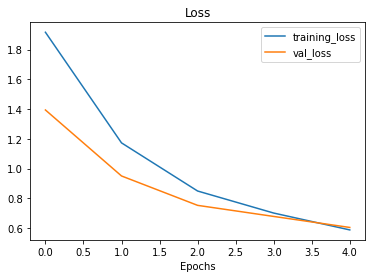

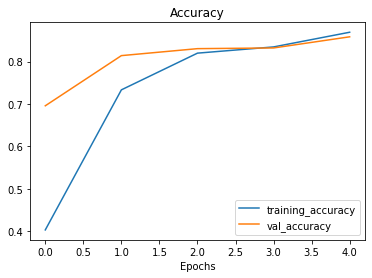

In [24]:
# Finally, let's check out our model's training curves
plot_loss_curves(history_10_percent)  # from the helper.py script!

In [25]:
# Awesome curves, very beautiful looking loss curves!
# That is what we want, we want the validation loss to be lining up with the training loss!
# Besides, they indicate that if we train for more, they may go lower and accuracy higher!

In [26]:
# So we have talked about extracting a feature vector out of the feature extraction model, but what is exactly that referring to?
# Let's see it next...

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280. But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280). (Remember that None is there to indicate the case of batches, leaving room for our model to go through our data in batches, so None would be batch_size or 1 if it is only one sample).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to `GlobalAveragePooling2D`, which transforms a 4D tensor into a 2D tensor.

The feature vector in the cases before is what comes out after the GlobalAveragePooling2D layer; and that it gets feed to the output layer, which is the only one that gets trained. So, this feature vector, of shape (None, 1280) in this case, is a representation of our input data that the trained model has learned; due to its own patterns (previously learned).

In [27]:
# Define the input shape
input_shape = (1, 4, 4, 3)   # just to show it, the real dimensions would be (1, 7, 7, 1280), it is easier to visualize this shape and see what is going on!

# Create a random tensor - simulates input data/image that is passed through our model
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [28]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)  # you can always call layers on their own and analyze what they do!
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")                                     # we pass the input between brackets, as when we use the functional model!

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [29]:
# So the global average pool tensor condenses the input!
# Gets rid of the two middle dimensions, so it converts it into a feature vector! From a tensor, to a vector!

In [30]:
# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [31]:
# The Global Average Pooled 2D tensor condenses the feature tensor into a feature vector!
# The feature vector is then input to our final dense layer, output layer.

More explanation on the documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

In [32]:
# So what operation happened! It actually just averaged the values across these two middle axes.
# So let's replicate the operation!

In [33]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])  # this says: reduce the input tensor to the mean of the values across axes 1 and 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Boom! That gives the same result as using the layer! Cool!

So doing this, not only makes the output of the base model compatible with the input shape requirement of our output layer, the Dense layer we added, it also condenses the information, found by the base model, into a lower dimensional feature vector!

This is one of the reasons why transfer learning in the previous module was called feature extraction, because this feature vector is what we are looking for from our base model! You want to extract the features our base model has learned of what it is in an image (that for us are just numbers, but the model understands it!). This is the representation our model has learned/found of a particular image or sample of data going through it, and then we train the output layer on this.

**Practice**: Try to do the same of the above 2 cells, but this time using `GlobalMaxPool2D`...and see what happens.

In [34]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)  
print(f"2D global max pooled random tensor: \n {global_max_pooled_tensor}\n")                                    

2D global max pooled random tensor: 
 [[0.9058464 1.1603122 1.6994323]]



In [35]:
tf.reduce_max(input_tensor, axis=[1, 2]) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [36]:
# Boom! The same!

**Important note**: One of the reasons **feature extraction transfer learning** is named how it is named it is because what often happens is that the pretrained model outputs a **feature vector** (a long tensor of number which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()`, which can then be used to extract patterns out of for our own specific problem.

### What is a feature vector?

* A feature vector is **a learned representation of the input data** (a compressed form of the input data based on how the model sees it)
  * The model learns feature representation of the input data (e.g., a specific image) and outputs a feature vector.
  * Pooling is used to condense all of the most important features into the feature vector (it creates/outputs the feature vector).
  * Then we add our own classification layer or a dense (fully-connected) layer on the top of this output representations in the same shape as the number of classes we have as input. We feed the feature vectors to this layer as input and this layer is trained based on them. This output layer, outputs a softmax prediction probability array with the same shape as the number of classes we have. 

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...how about we set up a bunch of experiments to find out (we start small and we build up as we go):

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation. 
2. `model_2` - use feature extraction transer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> **Note**: Throughout all experiments, the same dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.
> **Note**: There is no way you can tell what experiments to run, how do you know that beforehand? There is no way, you can't. It is only with lots of practice, lots of experimenting that you start to develop a hunch for the things that you should try.

## Getting and preprocessing data for model_1

In [37]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")  # from the helper library

--2022-09-26 11:06:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   108MB/s    in 1.2s    

2022-09-26 11:06:27 (108 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [38]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"  # same data across all our experiments

In [39]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")  # from helper functions library

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [40]:
# Now we only 7 training examples for each class!! Crazy reduction of the training data set size!

In [41]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical", # multiclass!
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [42]:
# As seen before, we only have 70 images to go through in our training data set!
# But 2500 testing images!

In [43]:
# We are missing the data augmentation part! Let's build it this time as a layer within the model!
print(tf.__version__)

2.8.2


## Adding data augmentation right into the model

Previously we have used different parameters in the `ImageDataGenerator` class, when the data was preprocessed. Now we are going to use a feature included in TF 2.2+ which enables adding data augmentation as a layer.

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()` (by the time you read this, it might not be experimental anymore and it could be called without that part).

Documentation here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster, directly benefits from GPU acceleration) rather than CPU. `ImageDataGenerator` makes the process slow as it uses CPU and does not benefit from GPU for the data augmentation process. The preprocessing layers have the benefit of run in the GPU, so it makes the process much faster!

* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere. To make predictions with our model, inference, the data will not be augmented. Data augmentation in preprocessing layers is only turned on during training, not at inference.

> **Extra remark**: When passed as a layer to a model, data augmentation is automatically **turned on during training** (augments training data) but **turned off during inference** (does not augment testing data or new unseen data).






In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [45]:
# Create data augmentation stage with horizontal flipping, rotation, zooms, etc.
# The type of data augmentation is a hyperparameter that you can tune, you have to experiment with the augmentation that is better for your data!
data_augmentation = keras.Sequential([  # we can create a layer for our functional API models out of the Sequential API
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2)
    #preprocessing.Rescale(1/255.)    # Keep for models like Resnet50v2 but EfficientNet's have rescaling built in, so this layer is not needed
], name="data_augmentation")

In [46]:
# We have just created data augmentation as a layer

### Visualize our data augmentation layer (and see what happens to our data)


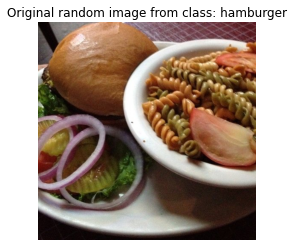

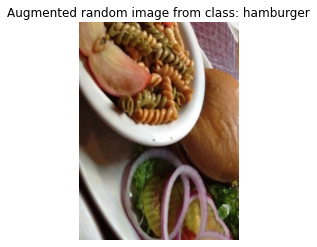

In [47]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)  # selects a random class
target_dir = "10_food_classes_1_percent/train/" + target_class 
random_image = random.choice(os.listdir(target_dir)) # picks a random image from the class directory
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)    # reads the image as a np.array that we can convert to tensors if we want to
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)   # the Keras Sequential model we created above; Training=True, otherwise it does not apply the augmentation; works like in inference time!
plt.figure()
plt.imshow(augmented_img/255)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [48]:
# As we can see data augmentation increases the diversity of our data artificially!
# Now we know what the data augmentation layer is doing to our images before they go through by our model!
# And all this is happening in the GPU! Vamos!
# What we do here is trying to make it harder for our model to learn these images so that when it goes to an image it hasn't seen before, hopefully if it has learned the patterns on harder images, it will detect what is going on in an image it has not seen! 

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation (as a layer)



In [49]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # we want our own top layer (output Dense layer)
base_model.trainable = False # we want to keep all the patterns/weights the same, as pretrained on ImageNet, as this is a feature extraction model

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)  # only on the training data!

# Give base_model the inputs (after augmentation) and do not train it
x = base_model(x, training=False)  # reiterating we do not want to train the base model, not even after the data augmentation

# Pool output features of the base model - so, condense the outputs of the previous layers/base model
# Basically we want the output tensor of the base model/layers to be condensed into a feature vector before feeding to the output layer
# We can condense using Pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)  # it is a layer, so the input is specified after the call of the layer (right-hand side), otherwise would be a parameter in the call

# Put a dense layer on as the output - our own top layer - 10 classes, multiclass
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)  # as it is a layer, it takes the inputs separately on the right hand side

# Make a Model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)  # we pass the inputs to the model, and also the outputs and it stacks all the layers together

# Compile the model
model_1.compile(loss="categorical_crossentropy",   # categorical data
                optimizer=tf.keras.optimizers.Adam(),   # it could be changed as it is a hyper-parameter
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,   # the same on all the experiments
                                validation_steps=int(0.25 * len(test_data)), # using just 25% of the test data for validation
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",  # track model training logs
                                                                       experiment_name="1_percent_data_aug")])  

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220926-110632
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4505 - accuracy: 0.1000

3/3 [==============================] - 12s 3s/step - loss: 2.4505 - accuracy: 0.1000 - val_loss: 2.2084 - val_accuracy: 0.1793
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1698 - accuracy: 0.2714 - val_loss: 2.1127 - val_accuracy: 0.2434
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9421 - accuracy: 0.4857 - val_loss: 2.0022 - val_accuracy: 0.3207
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8234 - accuracy: 0.5000 - val_loss: 1.8979 - val_accuracy: 0.3931
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.5864 - accuracy: 0.6857 - val_loss: 1.8139 - val_accuracy: 0.4424


In [50]:
# The val_accuracy is around 44%, so not as good as the baseline model, but we are using a tiny amount of data and it is even better than the whole model we built from scratch in previous modules! Awesome power of transfer learning!
# The training data is just 7 images per class, absolutely awesome results then!
# The original paper had a slightly better accuracy but using way more data!

In [51]:
# A good way to learn ML/DL is find a paper, try to reimplement it or try to beat it with some other sort of model!

In [52]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [53]:
# The trainable parameters are only the ones in the output layer
# The non-trainable are the ones on the original model EfficientNetB0, prelearned patterns on ImageNet!

In [54]:
# Evaluate on the full test dataset, as now during the training we just validate on 25% of the test data at each step, so the training speeds up!
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 1.8288 - accuracy: 0.4256


[1.8288179636001587, 0.42559999227523804]

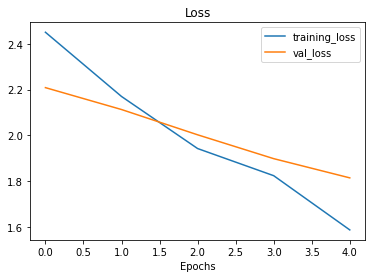

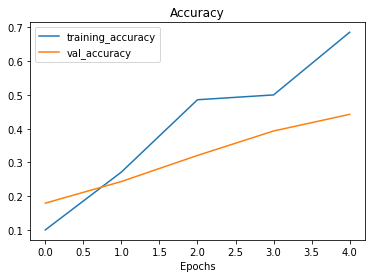

In [55]:
# How do the loss curves look?
plot_loss_curves(history_1_percent)   # function from helper functions library

In [56]:
# They are quite good loss curves, we want them as close as possible!
# They seem to be heading also in the right directions, loss is going down at the end of 5 epochs and the accuracy is going up!
# So maybe if we kept training the model, it might improve!
# That could be future work, now let's continue building more models, experimenting!

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation (as a layer)

In [57]:
# Get 10% of data...(uncomment if you do not have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

# Set data directories
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [58]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [59]:
# 75 images per class in the training set
# 250 in the test set per class!

In [60]:
# Create the data loaders - set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical", # multiclass
                                                                            image_size=IMG_SIZE) 
                                                                                                  # we do not add batch size as default is 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [61]:
# Create model 2 with data augmentation built in (we rewrite it for practice but we could reuse it from above)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([   # each of the steps will act randomly so in the end does not matter the order in this case
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),  # we put in all 0.2 as they are good default values, but we could experiment with this to find more optimal parameters (if any)!
    preprocessing.RandomZoom(0.2),   # there might be a better set of values for each specific problem you are working on, but these are good defaults!
    preprocessing.RandomRotation(0.2),
    # preprecessing.Rescaling(1/255.)  # we do not need it as EfficientNetB's have rescaling built-in, but if we use other models that do not have it, such as ResNet50v2, we should use this and rescale your data!
], name="data_augmentation")

In [62]:
# data_augmentation.summary() will not work if the model is not build or fit first!

In [63]:
# Setup the input shape to our model
input_shape = (224, 224, 3)  # size of an image sample that the model is going to take in!

# Create a frozen base model (also called THE BACKBONE) -> BACKBONE = base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)  # we just want the layers underneath it, as we want to put our own custom top layer as we are building a feature extractor model
base_model.trainable = False  # freeze the weights of the base model so they are not trained during training!

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)  # data augmentation sequential model; so images will go in the input layer and then straight to the data augmentation layers/model. This layers augment our training images (augmentation does not occur for test data)
x = base_model(x, training=False) # pass the augmented images to the base model; but keeps the base model in inference mode (so training is turned off for them, the weights do not get updated and all layers are kept in inference mode). This also ensure that BatchNorm layers do not get updated!!! -> MORE HERE: https://keras.io/guides/transfer_learning/#build-a-model 
                                  # BATCH NORM layers should not be unfrozen during fine-tuning, because those statistics/patterns should be kept the same! This is the only layer that cannot be changed during fine-tuning!
                                  # Use base_model.summary() to see if the model includes Batch Normalization layers! Read more about it!
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)   # compresses the multi-dimensional Tensor that is output of the model into a feature vector
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)  # our top layer

model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Check the compiled model
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckPoint callback

A brief remember of Callbacks...

Callbacks are a tool which can **add helpful functionality** to your models during training, evaluation or inference.

Some popular callbacks are: *TensorBoard*, *Model CheckPointing* and *EarlyStopping*.

They can be called and found in: `tf.keras.callbacks.CallbackName()`.

The **ModelCheckpoint callback** intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

Documentation about the ModelCheckpoint callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [65]:
# Set checkpoint path - location where the checkpoints will be saved
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"   #ckpt is the extension for a checkpoint saved file

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,  # we could save the whole model or only the weights
                                                         save_best_only=False,  # would save only the weights for the best metric value
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)  # verbosity of the output
# All previous values could be changed to our needs, this is just a demo of using some parameters!

### Fit model_2 passing in the ModelCheckpoint callback

In [66]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5   # introducing a new variable here, that will make sense once we apply fine-tuning, as we will train the feature-extraction model for X epoch and then fine-tune the model for another X epochs
history_10_percent_data_aug = model_2.fit(train_data_10_percent,              # when applying fine-tuning, you usually train the feature extraction model for a few epochs, which trains the output layer, and then you fine-tune later on 
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),  # validate only on 25% of the test data
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])  # callbacks are a list!

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220926-110710
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0151 - accuracy: 0.3160
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 23s 682ms/step - loss: 2.0151 - accuracy: 0.3160 - val_loss: 1.4935 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3674 - accuracy: 0.6640
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 417ms/step - loss: 1.3674 - accuracy: 0.6640 - val_loss: 1.0814 - val_accuracy: 0.7582
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0800 - accuracy: 0.7293
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 391ms/step - loss: 1.0800 - accuracy: 0.7293 - val_loss: 0.8694 - val_accuracy: 0.7878
E

In [67]:
# Model saves checkpoints every epoch, and it overrides the checkpoint saved in the previous epoch (how it is configured now)
# The model does not seem better than model_0, let's check the performance of the models on the full test data!

In [68]:
# What were model_0 results?
model_0.evaluate(test_data)  # backbone model results

79/79 [==============================] - 7s 74ms/step - loss: 0.6162 - accuracy: 0.8428


[0.6161926984786987, 0.8428000211715698]

In [69]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6927 - accuracy: 0.8104


[0.69267338514328, 0.8104000091552734]

In [70]:
# The difference between model_0 and model_2 is only adding data augmentation
# As we can see, in this case, data augmentation resulted in worse results! Interesting!

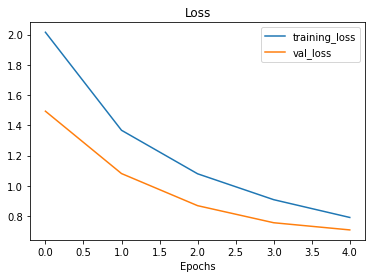

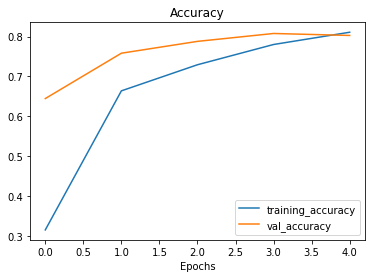

In [71]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [72]:
# Wow! Amazingly beautiful loss curves!! This is what we want! They are close together and facing same direction!
# This also says that if we keep training, what might happen is that our model will probably improve!
# Looks both lines are going in the right direction! Also validation accuracy is keeping up training accuracy, so maybe training for a few epoch more pushes it to the limit!

In [73]:
# So we saved the weights using the Checkpoint callback (only the weights in this case), let's see how can we use them!

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint. 

This is helpful, for instance, if training takes a long time and it does not provide good results and you might want to get back to a previous model results trained before and retrain again from there.

In [74]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)  # overriding model_2 existing weights with the saved ones

In [75]:
# Evaluate model_2 with loaded weights, to verify it is the same model we saved (the results on test_data should be the same)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6927 - accuracy: 0.8104


In [76]:
# If the results from our previuosly evaluated model_2 match the loaded weights results, everything has worked out well
results_10_percent_data_aug == loaded_weights_model_results

False

In [77]:
# Sometimes it might be False if the precision of the stored numbers is not the same, very small decimal points (precision) may affect the result, even though in this case worked perfectly!

In [78]:
# Check to see if loaded morel results are very close to our previous non-loaded model results
# If the check before resulted on False, we can check if it is because of a precision issue
# We can check np.isclose() to check if the values on two arrays are very close (within a tolerance)
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [79]:
# Check the difference between the two results (discrepancy between the results)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


In [80]:
# So sometimes the differences are due how to compute store numbers, that is the precision of the storage
# We can use np.isclose() to check if the those numbers are close enough within some certain tolerance
# We also checked the actual difference, and we can check that it is very, very small...caused by a precision issue!
# Let's continue with our experiments!!

## Model 3: Fine-tuning an existing model on 10% of the training data 

Up to now we were performing **feature extraction transfer learning**. Now we are going to explore **fine-tuning transfer learning**, where we unfreeze some layers of the base model (as opposed to *feature extraction transfer learning* where all layers are kept frozen) and train them!

So, briefly, before all layers were frozen in our feature extraction model (backbone/base model). The output of the base model went through a global average pooling length and we got a feature vector. On top of that feature vector, we placed our own dense layer because when we imported the backbone model, we used the parameter include_top = False. So the top layer output has the same shape as the number of input classes that we have.

So now we are going to do fine-tuning. Previously the whole backbone model was frozen, but in fine tuning, only some of the layers stay frozen and we unfreeze the patterns in some other layers. We freeze and unfreeze them to make them trainable, that is, that the patterns in the unfrozen layers get updated during training. How many layers do we need to unfreeze? This is an arbitrary number, this is one of the experiments you can run. Check also paper recommendations as well on how many layers should you unfreeze at a time and train. These unfrozen layers will get fine-tuned on our own custom data. We usually unfreeze layers closer to the top if we do not unfreeze the whole model. Because, in convolutional layers, usually the base or bottom layers learn more general features like larger shapes in images and we want to keep these larger features frozen because they are usually pretty good, while the higher-end layers, the ones closer to the output layer, learn more fine grained feature features. The features to learn are decided by the own layers, we do not establish them, but that is the general understanding on how features are learned. 

**Important note**: fine-tuning usually works best **after** training a feature extraction model for a few epochs with large amounts of custom data. 

So for fine-tuning, usually the workflow is: before we fine-tune any layers in existing architecture, we build a feature extraction model first, you train the weights in the output layer, and then you unfreeze some of the layers and keep this layer trained on the custom data.

Let's see it in action!

In [81]:
# Check layers in our loaded model, and if they are trainable
model_2.layers

In [82]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8ff5af2d10> True
<keras.engine.sequential.Sequential object at 0x7f8ff5aec510> True
<keras.engine.functional.Functional object at 0x7f8ff575dcd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8ff21b0b10> True
<keras.layers.core.dense.Dense object at 0x7f8ff5b0a650> True


In [83]:
# So we see the base model layers, the one between the data augmentation and Global average are frozen, trainable = False
# So the first two layers are trainable but actually do not learn anything, then the base model's weights are not updated/trained
# And the last two layers are trainable
# So a we established before base_model.trainable = False, it is actually the only that reports to be non-trainable

In [84]:
# We can further inspect this...
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for index, layer in enumerate(model_2.layers[2].layers): # inspecting all layers in the base model 3rd layer, which are actually the layers of the base model
  print(index, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [85]:
# Confirmed that all these layers are not trainable
# All these layers are the components of EfficientNetB0...can you image code that by hand?
# That is the power of transfer learning, we can leverage the power of all these layers pretrained!

In [86]:
# How many trainable variables (i.e., weight/patterns that can be updated) are in our base model?
print(len(model_2.layers[2].trainable_variables))  # currently no trainable variables, so output is 0, all frozen

0


In [87]:
# How can we perform fine-tuning?
# How can we make only the top-10 layers of the model trainable?

# To begin fine-tuning, let's start by setting the last 10 layes of our base_model.trainable = True
base_model.trainable = True  # make all model trainable now

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:  # get all layers except the last ten
  layer.trainable = False  # and set their trainable parameter to False

# Recompile (we have to recompile our models every time we make a change in a parameter)
# As base_model is part of model_2, we have to recompile everything so the changes are effective!
model_2.compile(loss="categorical_crossentropy",  # multiclass problem
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # lowering the learning rate for fine-tuning, see the explanation below
                metrics=["accuracy"])                           # when fine-tuning, you tipically want to lower the learning rate by 10x

In [88]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable) 

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [89]:
# We can confirm that the last 10 layers are now trainable! The rest of the model is not!

**One more rule for fine-tuning**

As we are updating already learned weights in an existing model, we do not want those weights to be updated too much (and make the model much worse). So, we have to tune the learning rate parameter to ensure that the updates are not too much. The **learning rate** dictates how much a mode, should update its internal patterns or internal weights (how much it should learn) epoch to epoch or sample to sample based on the loss function as well as the optimizer.

So, in fine-tuning, because the internal backbone layers have already learnedsome patterns on an existing data set, we do not want to drastically change those patterns, as it that would result in overfitting.

**Note**:  When you start to fine-tune, it is best practice to lower your learning rate by some amount. How much? This is a hyper-parameter you can tune (you can also use the learning rate finding trick we used in a previous module), but a good rule of thumb is to decrease it at least 10x (though different sources will claim other values). A good resource for information is the ULMFit paper -> https://arxiv.org/abs/1801.06146

In [90]:
# Now that we have unforzen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))     # before it was 0, now it is not!

12


In [91]:
# What are these variables?
model_2.trainable_variables  # current values of weights that are on the now trainable tensors

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [92]:
# Fine tune for another 5 epochs (after training a feature extraction model for 5 epochs, that is how the fine-tuning workflow works)
# The fine-tuning worklow is first train just the final output layer on custom data for some time (feature extraction), and then unfreeze some close-to-top layers and do fine tuning on all of them!
# The whole objective of fine tuning is to try to squeeze out some extra performance from your model that is more attuned to your own custom data! (which may not always work, that is why we experiment!)
fine_tune_epochs = initial_epochs + 5   # total amount of training will be 10! See below for a better understanding

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,    # the model was updated from a feature_extraction model to a fine-tuning, after we recompiled it before! Otherwise it would continue being as before!
                                               epochs=fine_tune_epochs,   # total amount of training will be 5 epochs
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),  # so the model fits a bit quicker
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # it specifies the epoch where it has to start fitting our model, so it starts to fit where we left off before! We set it in this case to start training (fine tuning) from previous last epoch!
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10_layers")])  

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20220926-110852
Epoch 5/10
24/24 [==============================] - 19s 461ms/step - loss: 0.6789 - accuracy: 0.8107 - val_loss: 0.5847 - val_accuracy: 0.8092
Epoch 6/10
24/24 [==============================] - 8s 340ms/step - loss: 0.5593 - accuracy: 0.8333 - val_loss: 0.5392 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - 9s 344ms/step - loss: 0.5089 - accuracy: 0.8440 - val_loss: 0.5383 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 8s 321ms/step - loss: 0.4442 - accuracy: 0.8533 - val_loss: 0.5472 - val_accuracy: 0.8191
Epoch 9/10
24/24 [==============================] - 9s 331ms/step - loss: 0.4110 - accuracy: 0.8560 - val_loss: 0.5300 - val_accuracy: 0.8158
Epoch 10/10
24/24 [==============================] - 9s 344ms/step - loss: 0.3589 - accuracy: 0.9000 - val_loss: 0.4796 - val_accuracy: 0.8405


In [93]:
# Fine-tuning usually takes more time as feature extraction as it updates more layers, instead of just one
# But this also depends on the amount of data you are using to train, etc.

In [94]:
# So now the weights of model_2, which is actually model_3, has been fine tuned for another 5 epochs (the last 10 layers)
# Let's see the real results testing on the whole test data

In [95]:
# Evalute the fine-tuned model (model_3 which is actually model_2 fine-tuned for another five epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4957 - accuracy: 0.8296


In [96]:
# How did we finish before?
results_10_percent_data_aug

[0.69267338514328, 0.8104000091552734]

In [97]:
# Wow! Not bad at all, we gained almost a 3% performance points increase by fine-tuning the last ten layers for five epochs!
# Amazing!!
# Let's inspect this more...

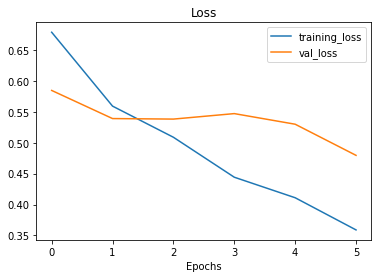

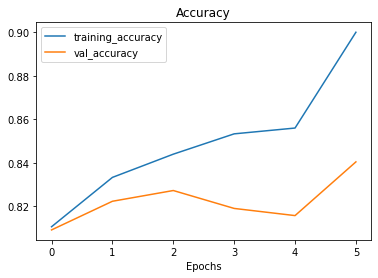

In [98]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [99]:
# A bit staggering curves, but this shows only the last 5 epochs of training, whereas our model has trained for a total amount of 10 epochs so...
# Let's plot and compare the loss curves before fine tuning and after fune tuning, so we can see the real benefits of it!

The `plot_loss_cuves` function works great with models which have only been fit once. However, we want something to copmpare one series of running `fit()` with another (e.g., before and after fine-tuning). So, we actually want something to compare histories! Let's code it!

In [100]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):   # mispelling is done on purpose, correct would be histories
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics so we have the total length of the metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)  # 2 rows, 1 column, first element
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Validation accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")  # -1 used as the index starts at 0, so epoch 5 is actually 4 in the plot!
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.subplot(2, 1, 2)  # 2 rows, 1 column, second element
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Validation loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")  # -1 used as the index starts at 0, so epoch 5 is actually 4 in the plot!
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

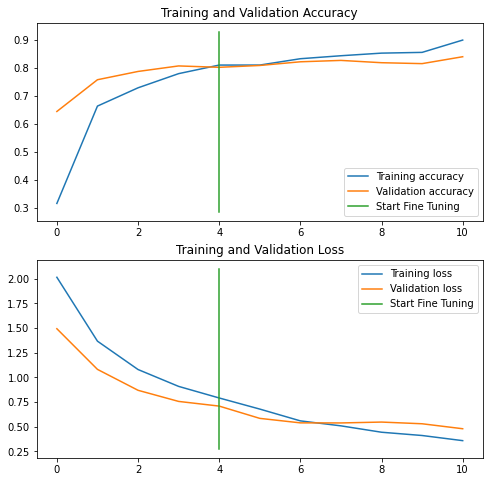

In [101]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

In [102]:
# Awesome graphs there! 
# Regarding accuracy, we can see that we gained a few percentage points after we started fine-tuning on the training and validation accuracy!
# Regarding loss, the best results come from the initial epochs (feature extraction model training), and after that the loss curves stay quite together until the last epochs, where it seems that is may be potentially starting to overfit (training loss going lower and separating from val loss)!
# Good point is that the training curves are staying very close to each other!

**Note 1**: Feature extraction usually works great with a lower amount of data, but if you want to tune some underlying weights of an existing architecture, usually you need quite a bit of data, that is. fine-tuning usually works well with (needs) more data.

**Note 2**: Regarding fine-tuning, the layers closer to the output layer get unfrozen/fine-tuned first, while the bottom layers tend to stay frozen (or are last to get unfrozen).

**Note 3**: Typical workflow for fine tuning transfer learning is: first you train a feature extraction model for some epochs and then you start to fine tune layers and the underlying model.

## Model 4: Fine-tuning an existing model on all the data

This is our last model experimentation. We have been adding complexity as we created new models. 

When you are working on DL projects, you start small and then slowly expand as you learn more (add gradually changes in data, preprocessing, model, etc). 

In [103]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")  # in helper functions library

--2022-09-26 11:10:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   227MB/s    in 2.2s    

2022-09-26 11:10:20 (227 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [104]:
# Setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
test_data = "10_food_classes_all_data/test"

In [105]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [106]:
# Now we have 750 images per training class
# 250 images per test class as before so we can compare all models (same data set all the time for testing)

In [107]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",    # multiclass setting
                                                                                 image_size=IMG_SIZE)
# the following line has been done before many times, bust repeated for the sake of clarity
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_data,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we have loaded in is the same as what we have been using for previous experiments (all experiments have used the same test dataset). 

Let's verify this...

In [108]:
# Evaluate model 2 (this is the fine-tuned on 10 percent data version, actually should be called model_3)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4957 - accuracy: 0.8296


[0.49571898579597473, 0.8295999765396118]

In [109]:
# This should match the previous results on previosly loaded test data (that should be the same)
results_fine_tune_10_percent

[0.49571889638900757, 0.8295999765396118]

In [110]:
# They match, cool! Just maybe some decimals do not match, but that is because of precision of number storage!

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights. Otherwise, current model_2 (which is actually model_3) might continue from where we finished the previous fine-tuning.

So, to do the workflow correctly of fine-tuning. We have to go back to the model as it was after feature extraction training, and then fine-tuned from there. In our case here, we can do that by loading a model from checkpoint. 

In [111]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
# Basically we restore the model to the 5th epoch after feature extraction, and then we fine-tune from there
# Only then we will be able to compare model_3 and model_4 (which are actually kept as model_2 variable with fine-tuning)
# The difference between model_3 and model_4 is just the amount of data used in the fine-tuning training...(10 percent vs. all data)
# so let's reverse the model back to the weights when it was trained as a feature extraction model
model_2.load_weights(checkpoint_path)

In [112]:
# Let's check that the weights have been properly reloaded by evaluating model_2 now
# Ideally, if the weights have been loaded well, the results of evaluation should be worse than the model_2 fine-tuned results (a few cells above)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6927 - accuracy: 0.8104


[0.6926732659339905, 0.8104000091552734]

In [113]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.69267338514328, 0.8104000091552734]

In [114]:
# Confirmed! They are the same weights as in the feature extraction model, the results are the same, so the model has reverted back successfully to the feature extraction days
# We can proceed to fine-tuning!

Alright, the previous steps might seem quite confusing, but all we have done is:

1. Trained a feature extraction transfer learning model for five epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3, even though in the code is still coded as model_2).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 (feature extraction model) to do the same steps as step 2 (fine tuning), except this time we are going to use all of the data (model_4, even though it will still be called model_2 in code).

In [115]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [116]:
# Even though we have reloaded the weights to model_2, the "trainability" of the layers remain the same, that is, trainable
# However, we have to dig further as this output is going to print out true if any of the layers within the EfficientNetB0 model is trainable
# Let's check them...

In [117]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):  # checking layers inside layer 2
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [118]:
# So confirmed, only the top 10 layers are trainable, as we modified them before! So even though we put back the weights to a previous checkpoint, the trainability of the layers did not change!

In [119]:
# What do we have to do every time we make a change to our models? COMPILE again!

In [120]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # decrease the learning rate as it is recommended when fine-tuning!
                metrics=["accuracy"])

In [121]:
# So all ready for fine-tuning!
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,   
                                           epochs=fine_tune_epochs,   # total epochs to train
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),  # to speed up the model training a bit
                                           initial_epoch=history_10_percent_data_aug.epoch[-1], # we want to start to do fine-tuning, where we left off with the feature extraction model, so the last epoch of the feature extraction history object!
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="full_10_classes_fne_tune_last_10_layers")])  

Saving TensorBoard log files to: transfer_learning/full_10_classes_fne_tune_last_10_layers/20220926-111044
Epoch 5/10
235/235 [==============================] - 63s 239ms/step - loss: 0.7267 - accuracy: 0.7672 - val_loss: 0.4217 - val_accuracy: 0.8503
Epoch 6/10
235/235 [==============================] - 48s 201ms/step - loss: 0.5919 - accuracy: 0.8111 - val_loss: 0.3467 - val_accuracy: 0.8832
Epoch 7/10
235/235 [==============================] - 44s 185ms/step - loss: 0.5183 - accuracy: 0.8315 - val_loss: 0.3085 - val_accuracy: 0.8947
Epoch 8/10
235/235 [==============================] - 41s 174ms/step - loss: 0.4935 - accuracy: 0.8444 - val_loss: 0.3139 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 38s 160ms/step - loss: 0.4479 - accuracy: 0.8549 - val_loss: 0.2942 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 37s 156ms/step - loss: 0.4119 - accuracy: 0.8675 - val_loss: 0.2906 - val_accuracy: 0.8947


In [122]:
# In reality this is model_4, as it is the feature extraction model (model_2), applying fine-tuning that may squeeze a little bit more performance out of the model
# For fine-tuning, first always do feature extraction then fine-tuning!
# These took more time as the more data, and more layer you train in fine-tuning, more computations are needed, hence more time to train per epoch!

In [123]:
# Wow! Best model so far, 90% accuracy!! It is using 10 times more data, and takes longer to train, but yielded the best model so far!

In [124]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)   # is actually model_4 (model_2 feature extraction version + fine tune on full data and unfreezing 10 last layers for five epochs)
results_fine_tune_full_data

79/79 [==============================] - 6s 73ms/step - loss: 0.3273 - accuracy: 0.8980


[0.3273005485534668, 0.8980000019073486]

In [125]:
# WOOOOOOOOOOOOOOWWW!! Awesome!!! Almost 90%!!!
# This shows the great power of transfer learning and the power of fine tuning!!
# But let's not stop and compare them well...

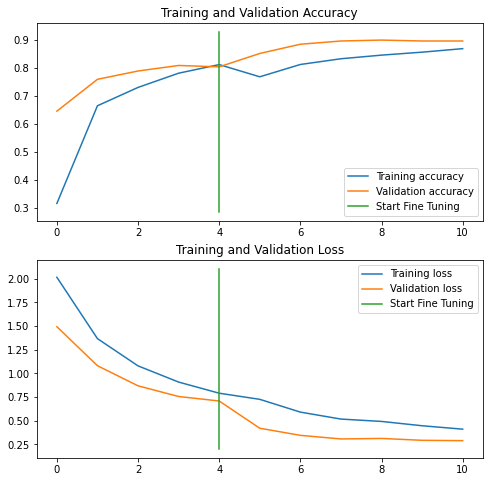

In [126]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [127]:
# Niiicee, amazing good looking plots!!
# Maybe if we train a few more epochs, we might squeeze out one more percent, maybe not, maybe less
# But overall, those are the directions we want things to be going...right up for accuracy, right down for loss!

In [128]:
# Awesome work! 
# Looks like extra data helped, those curves are looking great but, how can we compare our models in an easier way?
# Let's check and compare the training logs stored thanks to the TensorBoard callback!

## Viewing our experiment data on TensorBoard

**Note**: Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload data there or upload and delete it fast.

In [129]:
# View tensorboard logs of transfer learning modeling experiments (should be 5 models)
# Upload TensorBoard dev records
# Tensorboard is already installed in Colab (built-in), on other places should be installed
!tensorboard dev upload --logdir ./transfer_learning --name "Transfer Learning Experiments with 10 Food1010 Classes" --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
--one_shot # exits the uploader once it is finished uploading


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=ReQ058Fr2rJTSGQ5jh9nYs0NJqH3p8&prompt=consent&access_type=o

Loaded in TensorBoard.dev here -> https://tensorboard.dev/experiment/8aSrdOOyTk69Z7hAPgdyNA/

In [130]:
# Comparing the validation curves for accuracy we can see that...
# Model_0 with no data augmentation with just feature extraction performed better than when data augmentation was used (10% of the data in both cases)
# The fine-tuned models, the full data set performed better than 10% data
# The fine-tuned models start in epoch 5, as we started them there! Very cool graphs for comparison!
# If we analyze the loss, they reflect similar values to what we saw in the accuracy
# The full data set had the highest accuracy and lowest loss
# So what is all telling us...
# We could do more experiments (e.g., model_5 could be model_4 without data augmentation), so that would include some changes from model_0 into model_4...
# But that is up to you!

In [131]:
# View all your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

https://tensorboard.dev/experiment/8aSrdOOyTk69Z7hAPgdyNA/
	Name                 Transfer Learning Experiments with 10 Food1010 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   8aSrdOOyTk69Z7hAPgdyNA
	Created              2022-09-26 11:17:04 (14 seconds ago)
	Updated              2022-09-26 11:17:13 (5 seconds ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4308357
https://tensorboard.dev/experiment/abzrWfBdQYq0yzlWeKfEXQ/
	Name                 Transfer Learning Experiments with 10 Food1010 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   abzrWfBdQYq0yzlWeKfEXQ
	Created              2022-09-26 10:55:11 (22 minutes ago)
	Updated              2022-09-26 10:55:21 (21 minutes ago)
	Runs                 10
	Tags      

In [134]:
# How to delete a project from TensorBoard.dev -> you need the ID
!tensorboard dev delete --experiment_id abzrWfBdQYq0yzlWeKfEXQ

Deleted experiment abzrWfBdQYq0yzlWeKfEXQ.


In [135]:
# Check it has been removed successfully
!tensorboard dev list

https://tensorboard.dev/experiment/8aSrdOOyTk69Z7hAPgdyNA/
	Name                 Transfer Learning Experiments with 10 Food1010 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   8aSrdOOyTk69Z7hAPgdyNA
	Created              2022-09-26 11:17:04 (49 seconds ago)
	Updated              2022-09-26 11:17:13 (40 seconds ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4308357
https://tensorboard.dev/experiment/zqBVploVS6i4ZZjiw40X6Q/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   zqBVploVS6i4ZZjiw40X6Q
	Created              2022-09-21 13:25:03
	Updated              2022-09-21 13:25:08
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes    

Module's content finished!! Good job! EXTRA CURRICULUM AND EXERCISES [HERE](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/README.md#-05-transfer-learning-in-tensorflow-part-2-fine-tuning-exercises)